# Building model with keras to detect hate speech probability

This is a simple project to build a predictive model to predict if a tweet/comment contains offensive language, hate speech.

dataset is used from kaggle - https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset

end result is to build a model with rnn that detects hate/offensive comments/tweets and save word indexes to use for encoding inputs.


In [2]:
# imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
keras = tf.keras
layers = keras.layers
Tokenizer = keras.preprocessing.text.Tokenizer

load the csv file.

csv link - https://drive.google.com/uc?export=download&id=1kZENny35sk8my44iorHtrpFnE0sGBZTk

classes are hatespeech,offensive and neither(ok), represented by 0,1,2 respectively.

In [27]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1kZENny35sk8my44iorHtrpFnE0sGBZTk', header=0)

In [28]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


We don't need first 4 columns

In [29]:
# drop first 5 columns. we don't need them
df = df.drop(df.columns[:5], axis=1)

df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [30]:
feature_columns = ['hate_speech','offensive_language','ok']

## Preprocessing

Let's devide them into train,eval and test datasets.
there's about 25k records.

but before that we need to see few things.

In [36]:
dfc = df.copy()

df_hate_speech = dfc[dfc['class']==0]
df_offensive = dfc[dfc['class']==1]
df_ok = dfc[dfc['class']==2]

print("There are",len(df_hate_speech), "hate speech records.","and ",len(df_offensive),"offensive records","and",len(df_ok),"are ok")

There are 1430 hate speech records. and  19190 offensive records and 4163 are ok


In [37]:
df_ok.head(20)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
40,2,""" momma said no pussy cats inside my doghouse """
63,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,2,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."
70,2,"""@ArizonasFinest6: Why the eggplant emoji doe?..."
75,2,"""@BabyAnimalPics: baby monkey bathtime http://..."
115,2,"""@DomWorldPeace: Baseball season for the win. ..."
118,2,"""@DunderbaIl: I'm an early bird and I'm a nigh..."
119,2,"""@EdgarPixar: Overdosing on heavy drugs doesn'..."


There are 1430 hate speech records. and  19190 offensive records and 4163 are ok. Let's get the ratio

In [38]:
print("ratio to hate speech:offensive records:ok are ",len(df_hate_speech)/1430,":",len(df_offensive)/1430,":",len(df_ok)/1430)

ratio to hate speech:offensive records:ok are  1.0 : 13.41958041958042 : 2.9111888111888113


ratio to hate speech:offensive records:ok are  1.0 : 13.4 : 2.9

comparing to other records there are too many records are in offensive category. If we don't trim this ratio it will cause our predictive model to have a tendency to predict ok or hate speech tweets as offensive.

I will remove 1/2 of them that will trim it down to 9595.
total records will be trimmed down to 15185.

In [39]:
df_offensive = df_offensive[5000:14595]
len(df_offensive)

9595

In [43]:
df_offensive.head()

,class,tweet
6725,1,@morganwelborn you're a bitch
6726,1,@moyizzy naw negro
6728,1,@mrfoolycooly @DM___3 faggot alert
6729,1,@mrfoolycooly bitch ass scaring me! Lol you do...
6731,1,@mrfoolycooly im still where that giant muk sh...


In [51]:
# merge dataframes
dfc = pd.concat([df_hate_speech,df_offensive,df_ok], axis=0)

# shuffle the dataframe
dfc = dfc.sample(frac=1, random_state=42).reset_index(drop=True)
dfc.head()

,class,tweet
0,2,"Libs trash Saira Blair, an 18-year-old Republi..."
1,1,"I couldn't have no ""mama Joyce"" at my wedding...."
2,2,&#8220;@__Bino: Looking at nip rings I can't w...
3,1,Crazy bitch - Buckcherry &#128076;
4,1,Its bros ova hoes but wifey comes before ya bros


In [52]:
dfc.shape

(15188, 2)

We got 15188 records.

In [224]:
df = dfc.copy()
num_of_rows = len(df.index)
p80 = round(num_of_rows * 0.8)
p99 = round(num_of_rows * 0.99)

train_features = df[0:p80]
eval_features = df[p80:p99]
test_features = df[p99:]

train_labels = train_features.pop('class')
eval_labels = eval_features.pop('class')
test_labels = test_features.pop('class')
print(train_features.shape)
print(eval_features.shape)
print(test_features.shape)

(12150, 1)
(2886, 1)
(152, 1)


(12150, 1)

(2886, 1)

(152, 1)

In [225]:
train_labels.head()

0    2
1    1
2    2
3    1
4    1
Name: class, dtype: int64

## Encoding words

one_hot_encoding, max length, vocab size

In [226]:
padding_type = 'pre'
max_len = 60
trun_type='post'
oov_token = '<oov>'

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(train_features['tweet'])

vocab_size = len(tokenizer.word_index) + 1 # add 1 more, otherwise there will be a out ouf bound index error
vocab_size
# tokenizer.word_index

23731

vocab_size = 32751

In [227]:
# convert panda dataframe of labels to numpy array
train_labels = np.array(train_labels)
eval_labels = np.array(eval_labels)
test_labels = np.array(test_labels)

# convert each label to array of categorical values
train_labels = keras.utils.to_categorical(train_labels,3)
eval_labels = keras.utils.to_categorical(eval_labels,3)
test_labels = keras.utils.to_categorical(test_labels,3)

In [75]:
train_features_seq = tokenizer.texts_to_sequences(train_features['tweet'])
eval_features_seq = tokenizer.texts_to_sequences(eval_features['tweet'])

padding the arrays

In [76]:
train_features_seq = keras.utils.pad_sequences(train_features_seq,max_len,padding=padding_type)
eval_features_seq = keras.utils.pad_sequences(eval_features_seq,max_len,padding=padding_type)
len(train_features_seq[0])

60

In [77]:
train_features_seq = np.array(train_features_seq)
eval_features_seq = np.array(eval_features_seq)
eval_features_seq.shape

(2886, 60)

## Building the model

In [83]:
num_of_classes = len(feature_columns)

# neural network 01
model1 = keras.Sequential([
    keras.layers.Embedding(vocab_size,32,input_length=max_len),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(24,activation='relu'),
    keras.layers.Dense(num_of_classes,activation='softmax')
])

# neural network 02
model2 = keras.Sequential([
    keras.layers.Embedding(vocab_size,32,input_length=max_len),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(num_of_classes,activation='softmax')
])

In [84]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 32)            759392    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 776,227
Trainable params: 776,227
Non-trainable params: 0
_________________________________________________________________


## First model

In [ ]:
epochs = 200

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model1.fit(train_features_seq,train_labels,epochs=epochs,verbose=2,callbacks=[early_stopping])

It only ran 67 epochs because our early stopping functioning stopped the fitting. early stopping function is there to stop overfitting.

In [86]:
history.history['accuracy'][-1]

0.9995884895324707

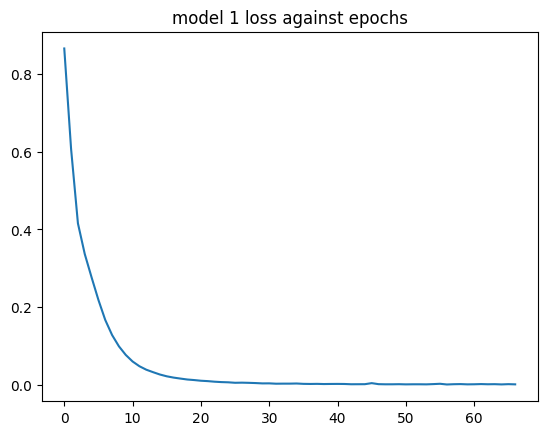

In [87]:
plt.plot(history.history['loss'])
plt.xLabel='epoch'
plt.yLabel='loss'
plt.title('model 1 loss against epochs')
plt.show()

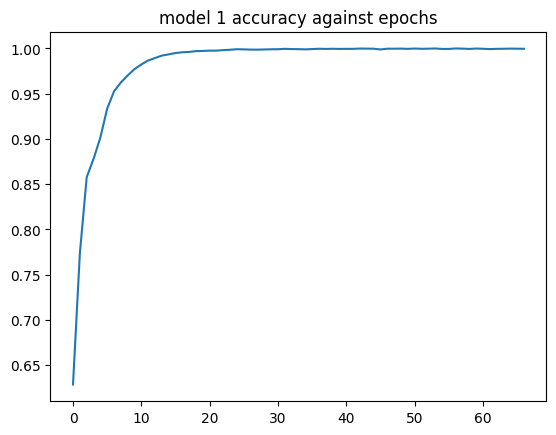

In [88]:
plt.plot(history.history['accuracy'])
plt.xLabel='epoch'
plt.yLabel='accuracy'
plt.title('model 1 accuracy against epochs')
plt.show()

After about 15-20 epochs model1 is fully trained.

In [91]:
loss1,acc1 = model1.evaluate(eval_features_seq,eval_labels)

91/91 [==============================] - 0s 2ms/step - loss: 1.7043 - accuracy: 0.7855


## model1's accuracy: 0.7855 with eval data.

## Second model

In [ ]:
epochs = 200

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model2_history = model2.fit(train_features_seq,train_labels,epochs=epochs,verbose=2,callbacks=[early_stopping])

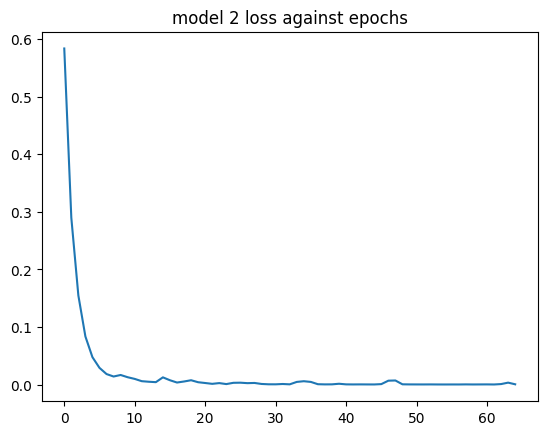

In [95]:
plt.plot(model2_history.history['loss'])
plt.xLabel='epoch'
plt.yLabel='loss'
plt.title('model 2 loss against epochs')
plt.show()

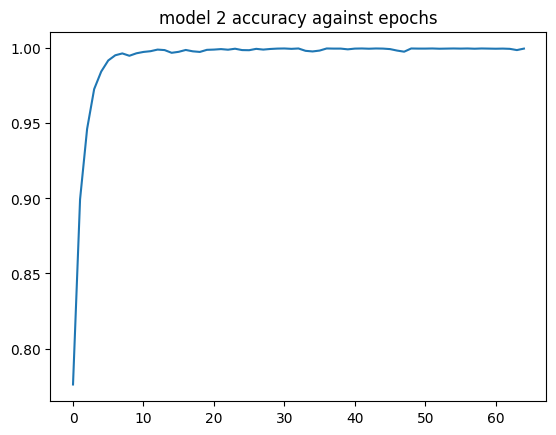

In [96]:
plt.plot(model2_history.history['accuracy'])
plt.xLabel='epoch'
plt.yLabel='accuracy'
plt.title('model 2 accuracy against epochs')
plt.show()

In [97]:
loss2,acc2 = model2.evaluate(eval_features_seq,eval_labels)

91/91 [==============================] - 3s 26ms/step - loss: 1.3185 - accuracy: 0.8198


## Model2's accuracy: 0.8198 with eval data

We'll use model2 since it is more accurate.

In [104]:
# reset the index of test_features and labels
test_features = test_features.reset_index(drop=True)
test_features.head()

,tweet
0,Elizabeth is a stupid hoe
1,"Just spoke w/ @HispanicLinkNS legend, mentor C..."
2,RT @anilkohli54: @mediacrooks so the ball did ...
3,RT @ImJustCeej: RT @BarackOMamba: RT @IntenseD...
4,"Montana, Wisconsin, Maine, New Hampshire, Nort..."


In [144]:
model2.save('hate_comment_detection_with_nlp_v2.h5')

In [3]:
model = keras.models.load_model('hate_comment_detection_with_nlp_v2.h5')

In [185]:
def manual_test(index):
  encoded = tokenizer.texts_to_sequences([test_features.loc[index]['tweet']])
  encoded = keras.utils.pad_sequences(encoded,60,padding='pre',truncating='post')
  preds = model.predict(encoded)
  pred = preds[-1]
  classification = feature_columns[np.argmax(pred)]
  confidence = np.max(pred) *100
  print("tweet is",test_features.loc[index]['tweet'],"\nprediction/classification is",classification,".confidence",confidence,"%")

index = input("pick a index below 152: ")
manual_test(int(index))

pick a index below 152: 49
1/1 [==============================] - 0s 43ms/step
tweet is Homemade Soup is very good with vegetables on the side with crackers http://t.co/LiRwGwkdzE 
prediction/classification is ok .confidence 98.52267503738403 %


Now let's predict our own comment.

first we have to encode that using tokenizer.

In [193]:
import json

with open('hate_comment_detection_with_nlp_word_index_v2.json', 'w') as file:
    json.dump(tokenizer.word_index, file)

In [5]:
import json
# Open the file containing the word index
with open('hate_comment_detection_with_nlp_word_index_v2.json', 'r') as file:
    data = json.load(file)

# Convert the JSON data to a dictionary
word_index = dict(data)

change the my_tweet and see the prediction

In [8]:
feature_columns = ['hate_speech','offensive_language','ok']

my_tweet = "I don't agree with you. I think your ideas dumb"

oov_token = '<oov>'

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.word_index = word_index
encoded = tokenizer.texts_to_sequences([my_tweet])
encoded = keras.utils.pad_sequences(encoded,60,padding='pre',truncating='post')

pred = model.predict(encoded)

classification = feature_columns[np.argmax(pred[-1])]
confidence = np.max(pred[-1]) *100
# if pred doesn't have at least 90% confidence I will consider as ok.
if confidence < 90:
  classification = 'ok'
print("\nprediction/classification is",classification)

1/1 [==============================] - 0s 23ms/step

prediction/classification is ok


### Points for viewers

* I did this just for testing out NLP in deep learning. Didn't go too much into optimising the model. You can tweak things and try to get a more efficient model.
* Model is trained to classify comments/tweets. It may not give accurate predictions for other sentences in other contexts.
